In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera_images(chessboard_files, shape):
     # calibrate camera here
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    for chessboard_file in chessboard_files:
        img = cv2.imread(chessboard_file)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find corners
        ret, corners = cv2.findChessboardCorners(gray, shape, None)
        # draw corners
        if ret:
            cv2.drawChessboardCorners(img, shape, corners, ret)
            plt.figure()
            plt.imshow(img)
            # generate image coordinates using mgrid
            objp = np.zeros((shape[0]*shape[1],3),np.float32)
            # fix x,y coordinate
            objp[:,:2] = np.mgrid[0:shape[0],0:shape[1]].T.reshape(-1,2)
            objpoints.append(objp)
            imgpoints.append(corners)
    # now calibrate camera
    ret, mtx, dist, rvect, tvects = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return ret, mtx, dist, rvect, tvects    

## Calibrate Camera

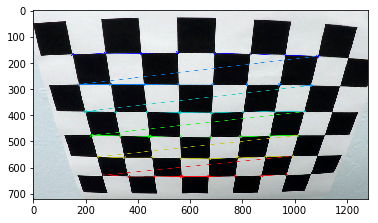

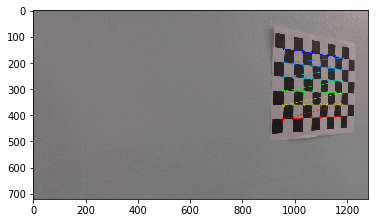

In [3]:
import glob
image_files = glob.glob('camera_cal/*.jpg')
ret, mtx, dist, rvect, tvects = calibrate_camera_images(image_files, (8,6))

## Undistort image

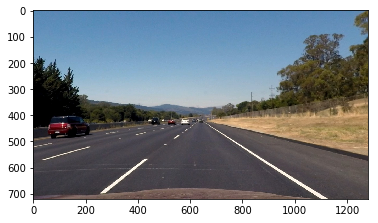

In [230]:
# undistort image here 
undistort_images = []
image_files = ['test_images/straight_lines2.jpg']
for image in image_files:
    img = cv2.imread(image)
    plt.figure()
    undistort_images.append(cv2.undistort(img, mtx, dist, None, mtx))
    plt.imshow(cv2.cvtColor(undistort_images[-1], cv2.COLOR_BGR2RGB))

## Color and Gradient Threshold

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    else:
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_img = np.uint8(grad_img / np.max(grad_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > thresh[0]) & (scaled_img < thresh[1])] = 1
    return final_img

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.sqrt(binaryx_img**2 + binaryy_img**2)
    scaled_img = np.uint8(binary_img / np.max(binary_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > mag_thresh[0]) & (scaled_img < mag_thresh[1])] = 1
    return final_img

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.arctan2(binaryy_img, binaryx_img)
    final_img = np.zeros_like(binary_img)
    final_img[(binary_img > thresh[0]) & (binary_img < thresh[1])] = 1
    return final_img



Absolute Image Threshold


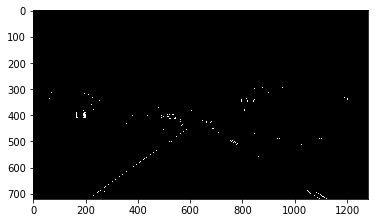

In [6]:
abs_image = abs_sobel_thresh(undistort_images[-1], thresh=(90,255))
print ("Absolute Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Magnitude Image Threshold


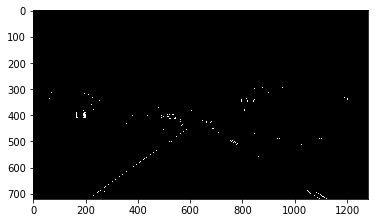

In [7]:
mag_grad_image = mag_thresh(undistort_images[-1], mag_thresh=(110,255))
print ("Gradient Magnitude Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Direction Image Threshold


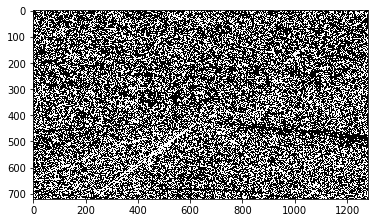

In [8]:
dir_image = dir_threshold(undistort_images[-1], sobel_kernel=15, thresh=(0.7, 1.3))
print ("Gradient Direction Image Threshold")
plt.figure()
plt.imshow(dir_image, cmap='gray')

In [9]:
# HLS channel thresholding 
def s_channel_thresholding(img, threshold=(95,255)):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_chan = hsv_img[:,:,2]
    print(s_chan.shape)
    binary_img = np.zeros_like(s_chan)
    binary_img [(s_chan > threshold[0]) & (s_chan < threshold[1])] = 1
    print (s_chan > threshold[0])
    return binary_img
    

(720, 1280)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


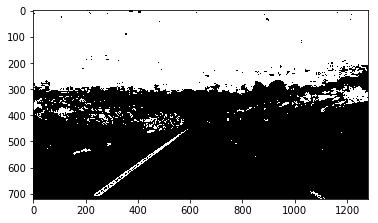

In [10]:
plt.figure()
s_image= s_channel_thresholding(undistort_images[-1], threshold=(95,255))
#print(s_image.shape)
plt.imshow(s_image, cmap='gray')

In [11]:
# COMBINE THRESHOLDS
img = undistort_images[-1]
shape = img.shape[:2]
combine_mask_img = np.zeros(shape)
combine_mask_img[(s_image > 0) | ((mag_grad_image >0) & (dir_image > 0)) | (abs_image > 0)] = 1
plt.figure()


## Warp the image

[[  590.           443.52941895]
 [  670.           443.52941895]
 [ 1280.           690.        ]
 [  170.           690.        ]]


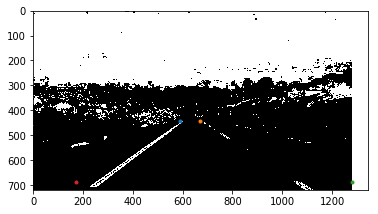

In [221]:
src = np.float32([
        [combine_mask_img.shape[1]/2 - 50, combine_mask_img.shape[0]/1.7 + 20], # tl
        [combine_mask_img.shape[1]/2 + 30, combine_mask_img.shape[0]/1.7 + 20], # tr
        [combine_mask_img.shape[1], combine_mask_img.shape[0] -30], # br
        [170, combine_mask_img.shape[0] - 30] # bl
    ])
print (src)
h, w = combine_mask_img.shape

plt.imshow(combine_mask_img, cmap='gray')
plt.plot(src[0][0], src[0][1], '.')
plt.plot(src[1][0], src[1][1], '.')
plt.plot(src[2][0], src[2][1], '.')
plt.plot(src[3][0], src[3][1], '.')

In [232]:
def warp_image(undistort_image, mtx, dist):
    # transform to gray
    #gray = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2GRAY)
    print(undistort_image.shape[1], undistort_image.shape[0])
    width, height = undistort_image.shape[1], undistort_image.shape[0]
    src = np.float32([
        [undistort_image.shape[1]/2 - 120, undistort_image.shape[0]/1.8 + 50], # tl
        [undistort_image.shape[1]/2 + 120, undistort_image.shape[0]/1.8 + 50], # tr
        [undistort_image.shape[1], undistort_image.shape[0] - 20], # br
        [0, undistort_image.shape[0] - 20] # bl
    ])
    tl,tr,br,bl = src
    print (src)
    
    width = int(np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2))
    height = int(max(np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2), np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2)))
    print ("height ", height)
    print ("width ", width)
    dst = np.float32([
        [0,0], # tl
        [width - 1, 0], # tr
        [width - 1, height - 1], # br
        [0, height -1] # bl
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistort_image, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, M, (tl,tr,br,bl)

1280 720
[[  520.   450.]
 [  760.   450.]
 [ 1280.   700.]
 [    0.   700.]]
height  576
width  1280


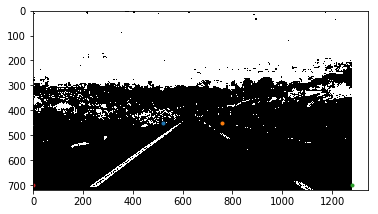

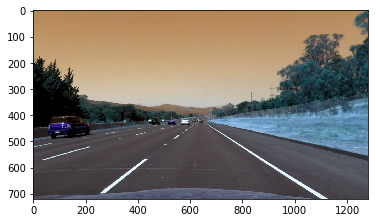

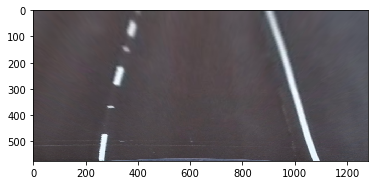

In [233]:
warped, M, src = warp_image(undistort_images[-1], mtx, dist)
plt.figure()
plt.imshow(combine_mask_img, cmap='gray')
plt.plot(src[0][0], src[0][1], '.')
plt.plot(src[1][0], src[1][1], '.')
plt.plot(src[2][0], src[2][1], '.')
plt.plot(src[3][0], src[3][1], '.')
plt.figure()
plt.imshow(undistort_images[-1])
plt.figure()
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
plt.imshow(warped, cmap='gray')